In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime as dt
import io
import requests
import matplotlib as mp
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.collections as col
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns
import math
import scipy as sp
import scipy.stats as stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.regressionplots import *
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import itertools
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
all_polls = pd.read_csv('all_polls.csv')

In [4]:
errorPolls = all_polls[['samplesize', 'error', 'bias', 'pollster', 'state', 'type_simple', 'partisan_race', 'polldistance', 'year', 'partisan_race', 'cand1_pct', 'cand2_pct', 'rightcall']]

In [5]:
#Removing some outliers. errorPolls has all the most relevant columns from allPolls with the
#outliers trimmed out. Only affects six polls.
errorPolls = errorPolls[errorPolls['error'] < 90]
errorPolls.reset_index(drop = True, inplace = True)

In [13]:
#generate mean error and standard deviation of error per pollster, log of error.
#To prevent log of zero errors, we replace errors of 0 with 0.01.
pollerror = all_polls.groupby('pollster').mean()
pollerror = pollerror[['error']]
pollstd = all_polls.groupby('pollster').std()
pollstd = pollstd[['error']]
pollerror.rename(columns = {'error':'pollster_error'}, inplace = True)
pollstd.rename(columns = {'error':'pollster_std'}, inplace = True)
errorPolls = errorPolls.merge(pollerror, how = 'left', left_on = 'pollster', right_on = 'pollster')
errorPolls = errorPolls.merge(pollstd, how = 'left', left_on = 'pollster', right_on = 'pollster')
errorPolls.fillna(0, inplace = True)
errorPolls.error.replace(0, 0.01, inplace = True)
errorPolls['log_error'] = np.log(errorPolls['error'])

C:\Users\marcu\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\marcu\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
#Generate a set of commonly used x and y values
sample_std = errorPolls[['samplesize', 'pollster_std']]
sample_error = errorPolls[['samplesize', 'pollster_error']]
error = errorPolls['error']
log_error = errorPolls['log_error']

In [15]:
basic_model = sm.OLS(error, sample_error).fit()
print(basic_model.rsquared_adj, basic_model.fvalue)

0.6113213966948299 7987.778860525593


In [16]:
basic_std_model = sm.OLS(error, sample_std).fit()
print(basic_std_model.rsquared_adj, basic_model.fvalue)

0.5551768095506242 7987.778860525593


In [17]:
log_basic_model = sm.OLS(log_error, sample_error).fit()
print(log_basic_model.rsquared_adj, log_basic_model.fvalue)

nan nan


In [18]:
log_basic_std_model = sm.OLS(log_error, sample_std).fit()
print(log_basic_std_model.rsquared_adj, log_basic_model.fvalue)

nan nan


In [19]:
#OLS does a good job of predicting maximum error but is much worse at predicting exact error.
#We need a different model here.
#I'll note that in this case the log of the data is worse, but it performed better
#for the max_error model, so I'll check both

In [20]:
#Many classifiers, such as random forests and naive Baysean, are models of binary clasification:
#Given data, differentiate between A and B. We have continuous data sets: error can be 0-100 inclusive
#and there are ~270 counties across 50 states and a few extras (i.e. DC).
#We need to pick a threshold for our data.

In [21]:
print(np.mean(errorPolls.error))
print(np.std(errorPolls.error))

5.485425364316677
4.84293420190412


In [22]:
#Mean error is 5.485, with 2/3 polls between ~1 and ~10.

In [23]:
print(len(errorPolls))
totalError = len(errorPolls)
print(len(errorPolls[errorPolls['error'] < 4.5])/totalError)
print(len(errorPolls[errorPolls['error'] < 4])/totalError)
print(len(errorPolls[errorPolls['error'] < 2])/totalError)
print(len(errorPolls[errorPolls['error'] < 1])/totalError)

10156
0.5195943284757779
0.4664237888932651
0.2471445450964947
0.11894446632532493


In [24]:
#Looks like if we want to halve the data, we should select error 4-4.5.
#We can go down to 2 and still have a quarter of the dataset to check, but going down to 1 seems
#overly ambitious.
#For the first pass, let's test thresholds of 4 and 2.

In [25]:
errorPolls['decentPoll'] = (errorPolls['error'] <= 4).values.astype(np.int)
errorPolls['goodPoll'] = (errorPolls['error'] <= 2).values.astype(np.int)
decentPoll = errorPolls['decentPoll'].values
goodPoll = errorPolls['goodPoll'].values

In [26]:
#Tests a multinomial naive Bayes on independent, dependent variables, returns train, test score
def mnb_report(x, y):
    ind_train, ind_test, dep_train, dep_test = train_test_split(x, y)
    mnb_basic = naive_bayes.MultinomialNB()
    mnb_basic.fit(ind_train, dep_train)
    train_pred = mnb_basic.predict(ind_train)
    test_pred = mnb_basic.predict(ind_test)
    train_score = sklearn.metrics.accuracy_score(dep_train, train_pred)
    test_score = sklearn.metrics.accuracy_score(dep_test, test_pred)
    f1_score = sklearn.metrics.f1_score(dep_test, test_pred)
    cm = confusion_matrix(dep_test, test_pred)
    return train_score, test_score, f1_score, cm

In [27]:
print(mnb_report(sample_error, decentPoll))

(0.5675462780622292, 0.5726664040961008, 0.4169801182160129, array([[1066,  305],
       [ 780,  388]], dtype=int64))


In [28]:
print(mnb_report(sample_distance_std, fourError))

NameError: name 'sample_distance_std' is not defined

In [29]:
#Good news: no evidence of overfitting. Bad news: Not a great model. I have a lot of things to test,
#so I need to move faster

In [30]:
#Setting up a list of ind, dep for the function to crunch
sample = errorPolls['samplesize']
poll_std = errorPolls['pollster_std']
poll_error = errorPolls['pollster_error']
year = errorPolls['year']
distance = errorPolls['polldistance']
partisan = errorPolls['partisan_race']
cand1_pct = errorPolls['cand1_pct']
cand2_pct = errorPolls['cand2_pct']
sample_std = errorPolls[['samplesize', 'pollster_std']]
sample_error = errorPolls[['samplesize', 'pollster_error']]
error = errorPolls['error']
log_error = errorPolls['log_error']
sample_distance_std = errorPolls[['samplesize', 'polldistance', 'pollster_std']]

In [31]:
best_ind_vars = []
best_dep_vars = []
#This function takes in a list of potential independent variables and variable combinations
#and another list of potential dependent variables.
#It tests a mnb model on each one and returns the best model and its score.
#Rewriting to store the best variables for later perusal.
def mnb_all_xy(x, y):
    model_results = []
    for ind in x:
        for dep in y:
            train_score, test_score, f_score = mnb_report(ind, dep[1])
            model_results.append([test_score, train_score, ind, dep[0], f_score])
    #Find the best n models
    #best_test = 0
    #best_train = 0
    #best_ind = ''
    #best_dep = ''
    best_f = 0
    #failed_models = 0
    #Loop through the results to find the best model
    #Best model defined as model with best test score
    for x in range(len(model_results)):
        #if model_results[x][4] == 0:
            #failed_models += 1
        if model_results[x][4] > best_f:
            #best_test = model_results[x][0]
            #best_train = model_results[x][1]
            best_ind_vars.append(model_results[x][2].columns)
            best_dep_vars.append(model_results[x][3])
            best_f = model_results[x][4]
    #print('Evaluated ', len(model_results), ' models.')
    #print('Best F-score: ', best_f)
    #print('Best independent variables: ', best_ind)
    #print('Best dependent variables: ', best_dep)
    #print('Best training data score: ', best_train)
    #print('Best test data score: ', best_test)
    #print('Failed models: ', failed_models)

In [32]:
#I'll briefly note that I spent an hour debugging this before I realized I had the variables
#wrong in the mnb_report call. Note to self: Check the simple stuff first.
#On the plus side, now I know more about vectorizers and matricies.

In [33]:
mnb_all_xy(ind_var, dep_var)

NameError: name 'ind_var' is not defined

In [34]:
#Looks like the model does best when it's set up to be more selective. We'll try again with a variety
#of score cutoffs.

In [35]:
errorPolls['fourError'] = (errorPolls['error'] <= 4).values.astype(np.int)
errorPolls['threeError'] = (errorPolls['error'] <= 3).values.astype(np.int)
errorPolls['twoError'] = (errorPolls['error'] <= 2).values.astype(np.int)
errorPolls['oneError'] = (errorPolls['error'] <= 1).values.astype(np.int)
errorPolls['halfError'] = (errorPolls['error'] <= 0.5).values.astype(np.int)
fourError = errorPolls['fourError'].values
threeError = errorPolls['threeError'].values
twoError = errorPolls['twoError'].values
oneError = errorPolls['oneError'].values
halfError = errorPolls['halfError'].values

In [36]:
dep_var = [['fourError', fourError], ['threeError', threeError], ['twoError', twoError], 
           ['oneError', oneError], ['halfError', halfError]]

In [37]:
mnb_all_xy(ind_var, dep_var)

NameError: name 'ind_var' is not defined

In [38]:
#The model seems to get better the more selective I get.
cutoff_point = [4, 3, 2, 1, 0.5]
cutoff_size = []
for cutoff in dep_var:
    cutoff_size.append(len(cutoff[1][cutoff[1] == 1])/10000)
print(cutoff_size)

[0.4785, 0.3752, 0.2566, 0.1267, 0.062]


In [39]:
#at the last, we're separating 600 from 9400. Let's plot this trend.

In [40]:
model_scores = []
for x in dep_var:
    model_scores.append(mnb_report(sample_std, x[1])[1])
print(model_scores)

[0.5588814493895234, 0.6187475384009452, 0.7317841669948799, 0.8633320204805042, 0.9417093343836156]


Text(0, 0.5, '% data under threshold')

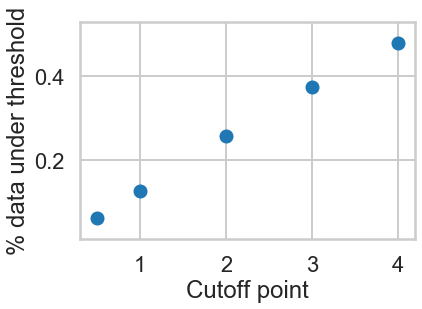

In [41]:
plt.scatter(x = cutoff_point, y = cutoff_size)
plt.xlabel('Cutoff point')
plt.ylabel('% data under threshold')

Text(0, 0.5, 'Model test score')

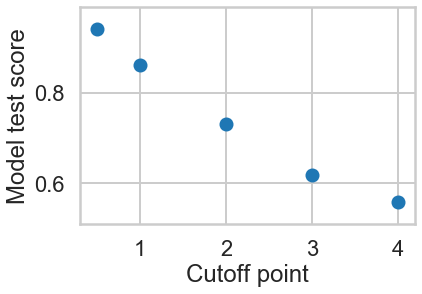

In [42]:
plt.scatter(x = cutoff_point, y = model_scores)
plt.xlabel('Cutoff point')
plt.ylabel('Model test score')

In [43]:
#My concern is that this model may tend towards predicting everything falls past the cutoff,
#which is punished less and less as we classify less of our pool as accurate.
#I want to evaluate this on F-score, because I'm more interested in my positives than
#my negatives - catching everything that meets the cutoff.
#Rewrote the functions to take this into account.

In [44]:
mnb_all_xy(ind_var, dep_var)

NameError: name 'ind_var' is not defined

In [45]:
#We've got more work to do. This is only about as good as an OLS model right now.
#Taking a sharper cutoff worstens the data. My model's aren't in any danger of overfitting,
#though, so I should be able to improve things by adding new data, keeping in mind that
#I need to be aware of dimensionality.
#So far, the best model I've found is sample size and mean pollster error against error.

In [46]:
#Adding log_error tracking

In [47]:
print(np.mean(errorPolls['log_error']))
print(np.std(errorPolls['log_error']))

-inf
nan


In [48]:
errorPolls['1.25_log_error'] = (errorPolls['log_error'] <= 1.25).values.astype(np.int)
errorPolls['1_log_Error'] = (errorPolls['log_error'] <= 1).values.astype(np.int)
errorPolls['.75_log_Error'] = (errorPolls['log_error'] <= .75).values.astype(np.int)
errorPolls['.5_log_Error'] = (errorPolls['log_error'] <= .5).values.astype(np.int)
errorPolls['.25_log_Error'] = (errorPolls['log_error'] <= .25).values.astype(np.int)
#Logging as five-quarters, four-quarters, etc
fiveQ_log_error = errorPolls['1.25_log_error'].values
fourQ_log_error = errorPolls['1_log_Error'].values
threeQ_log_error = errorPolls['.75_log_Error'].values
twoQ_log_error = errorPolls['.5_log_Error'].values
oneQ_log_error = errorPolls['.25_log_Error'].values

In [49]:
dep_var.append(['fiveQ_log_error', fiveQ_log_error])
dep_var.append(['fourQ_log_error', fourQ_log_error])
dep_var.append(['threeQ_log_error', threeQ_log_error])
dep_var.append(['twoQ_log_error', twoQ_log_error])
dep_var.append(['oneQ_log_error', oneQ_log_error])

In [127]:
print(errorPolls['1.25_log_error'])

0        0
1        1
2        0
3        0
4        0
        ..
10151    0
10152    0
10153    1
10154    0
10155    0
Name: 1.25_log_error, Length: 10156, dtype: int32


In [50]:
#Adding state tracking - need to convert state to numerical data for mnb to process

In [51]:
allStates = []
for x in errorPolls['state']:
    if x not in allStates:
        allStates.append(x)
print(allStates)
print(len(allStates))

['WV', 'NM', 'VT', 'NV', 'KS', 'PA', 'UT', 'MO', 'MA', 'RI', 'MI', 'NY', 'NH', 'MT', 'HI', 'ME', 'NE', 'TN', 'WA', 'WY', 'ID', 'VA', 'KY', 'AZ', 'MN', 'IA', 'OK', 'CO', 'FL', 'SC', 'WI', 'ND', 'AK', 'TX', 'CA', 'AR', 'NJ', 'LA', 'MD', 'OH', 'SD', 'MS', 'GA', 'OR', 'CT', 'AL', 'IN', 'IL', 'DC', 'US', 'DE', 'NC']
52


In [52]:
stateDict = {}
stateNum = 0
for abbr in allStates:
    stateDict[abbr] = stateNum
    stateNum += 1
print(stateDict)

{'WV': 0, 'NM': 1, 'VT': 2, 'NV': 3, 'KS': 4, 'PA': 5, 'UT': 6, 'MO': 7, 'MA': 8, 'RI': 9, 'MI': 10, 'NY': 11, 'NH': 12, 'MT': 13, 'HI': 14, 'ME': 15, 'NE': 16, 'TN': 17, 'WA': 18, 'WY': 19, 'ID': 20, 'VA': 21, 'KY': 22, 'AZ': 23, 'MN': 24, 'IA': 25, 'OK': 26, 'CO': 27, 'FL': 28, 'SC': 29, 'WI': 30, 'ND': 31, 'AK': 32, 'TX': 33, 'CA': 34, 'AR': 35, 'NJ': 36, 'LA': 37, 'MD': 38, 'OH': 39, 'SD': 40, 'MS': 41, 'GA': 42, 'OR': 43, 'CT': 44, 'AL': 45, 'IN': 46, 'IL': 47, 'DC': 48, 'US': 49, 'DE': 50, 'NC': 51}


In [53]:
errorPolls['stateNum'] = errorPolls['state']

In [54]:
errorPolls['stateNum'] = errorPolls['state'].replace(stateDict)

In [55]:
stateNum = errorPolls['stateNum']

In [56]:
#Adding polling type tracking

In [57]:
allPollTypes = []
for x in errorPolls['type_simple']:
    if x not in allPollTypes:
        allPollTypes.append(x)
print(allPollTypes)
print(len(allPollTypes))

['House-G', 'Pres-P', 'Gov-G', 'Sen-G', 'Pres-G']
5


In [58]:
pollDict = {}
pollNum = 0
for poll in allPollTypes:
    pollDict[poll] = pollNum
    pollNum += 1
print(pollDict)

{'House-G': 0, 'Pres-P': 1, 'Gov-G': 2, 'Sen-G': 3, 'Pres-G': 4}


In [59]:
errorPolls['pollNum'] = errorPolls['type_simple']

In [60]:
errorPolls['pollNum'] = errorPolls['type_simple'].replace(pollDict)

In [61]:
pollNum = errorPolls['pollNum']

In [62]:
print(len(ind_var))
print(len(dep_var))

NameError: name 'ind_var' is not defined

In [63]:
mnb_all_xy(ind_var, dep_var)

NameError: name 'ind_var' is not defined

In [64]:
#We've improved things by adding poll type tracking to the model. Still needs work, unfortunately.
#To note: adding poll type and state did not help.
#Going to try passing this to a random forest model, see how that likes it.

In [65]:
#Tried: OLS, naive Bayes, random forests. Other ideas: per SKlearn algorithm cheat sheet,
#elasticnet lasso or maybe linear SVC->KNeighbors->SVC ensemble classifiers. That's assuming
#I want to aggressively bin my data, of course.
#Lean towards random forests

In [66]:
#What are some other things I can do with R visualizations of the US?
#Option 1:Interactives showing trends over time. Not directly related to my project?
#Option 2: Visualize more data directly.

In [67]:
#Generates all combinations of variables of size n or less from an initial array of 
#1D independent variables.
#One consequence of this is that we can't keep giving the ind_vars their own names - I'll have
#to examine the dataframe afterwards.
def generate_combinations(ind_vars, n):
    all_combinations = []
    #omit n=1
    for x in range(n-1):
        #For input of 3, we want 2-3, not 0-1-2
        n_combinations = itertools.combinations(ind_vars, x+2)
        all_combinations = all_combinations + join_vars(n_combinations)
    return all_combinations

In [68]:
#Takes an itertools output, an iterator that produces lists of variable length, and returns
#returns a list of dataframes that are ready to be passed to the model
def join_vars(n_combinations):
    new_combinations = []
    for tuple_vars in n_combinations:
        new_combinations.append(pd.DataFrame(tuple_vars).transpose())
    return new_combinations

In [69]:
errorPolls['rightcall_int'] = (errorPolls['rightcall']).values.astype(np.int)
rightcall = errorPolls['rightcall_int'].values

In [70]:
dep_var = [['fourError', fourError], ['threeError', threeError], ['twoError', twoError], 
           ['oneError', oneError], ['halfError', halfError]]

In [71]:
dep_var.append(['fiveQ_log_error', fiveQ_log_error])
dep_var.append(['fourQ_log_error', fourQ_log_error])
dep_var.append(['threeQ_log_error', threeQ_log_error])
dep_var.append(['twoQ_log_error', twoQ_log_error])
dep_var.append(['oneQ_log_error', oneQ_log_error])

In [72]:
dep_var.append(['rightcall', list(rightcall)])

In [73]:
#Independent variables: samplesize, std of pollster, mean error of pollster
#TODO: Figure out why partisan keeps crashing in ind_combinations.

In [78]:
#ind_var = [sample, poll_std, poll_error, year, distance, partisan, cand1_pct, cand2_pct, stateNum,
          #pollNum]

In [77]:
ind_var = [sample, poll_std, poll_error, year, distance, cand1_pct, cand2_pct, stateNum, pollNum]

In [76]:
ind_combinations = generate_combinations(ind_var, 4)

KeyboardInterrupt: 

In [ ]:
#Test all combinations of up to 4 variables

In [ ]:
#I'm concerned that I've started fishing.
mnb_all_xy(ind_combinations, dep_var)

In [ ]:
#Best model: Consistently selects poll distance, rightcall, others variable.
#Still no evidence of overfitting, which is good, but I'm concerned that I'm just 
#fishing at this point.
#Not sure if I should continue working on this or take another approach

In [ ]:
#Next steps: Run mnb_all_xy a few times to find which variables are consistently valuable, 
#then move away from this and towards RF modeling.

In [ ]:
#Finding most consistently good variables

In [ ]:
for x in range(100):
    ind_combinations = generate_combinations(ind_var, 4)
    mnb_all_xy(ind_combinations, dep_var)
    print('completed test ', x)

In [ ]:
#Examine the results

In [745]:
print(best_ind_vars)

[Index(['samplesize', 'pollster_std'], dtype='object'), Index(['samplesize', 'pollster_std'], dtype='object'), Index(['samplesize', 'pollster_error'], dtype='object'), Index(['samplesize', 'polldistance'], dtype='object'), Index(['pollster_std', 'polldistance'], dtype='object'), Index(['pollster_error', 'polldistance'], dtype='object'), Index(['year', 'polldistance'], dtype='object'), Index(['samplesize', 'pollster_std'], dtype='object'), Index(['samplesize', 'pollster_std'], dtype='object'), Index(['pollster_std', 'year'], dtype='object'), Index(['pollster_std', 'polldistance'], dtype='object'), Index(['year', 'polldistance'], dtype='object'), Index(['year', 'polldistance', 'cand1_pct'], dtype='object'), Index(['year', 'polldistance', 'cand2_pct'], dtype='object'), Index(['samplesize', 'pollster_std'], dtype='object'), Index(['samplesize', 'pollster_std'], dtype='object'), Index(['samplesize', 'pollster_error'], dtype='object'), Index(['pollster_std', 'pollster_error'], dtype='object'

In [746]:
print(best_dep_vars)

['fourError', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'fourError', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'fourError', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'fourError', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'fourError', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'fourError', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'fourError', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'fourError', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'fourError', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'rightcall', 'fourError', 'rightcall', 'rightcall', 'rightcall'

In [749]:
print(best_dep_vars.count('rightcall'))

753


In [750]:
print(best_dep_vars.count('fourError'))

100


In [751]:
print(len(best_dep_vars))

853


In [752]:
print(len(best_ind_vars))

853


In [758]:
ind0 = best_ind_vars[0]

In [760]:
type(ind0)

pandas.core.indexes.base.Index

In [761]:
print(best_ind_vars[0])

Index(['samplesize', 'pollster_std'], dtype='object')


In [762]:
print(best_ind_vars[0][0])

samplesize


In [763]:
indClean = []
for x in best_ind_vars:
    indSmall = []
    for y in x:
        indSmall.append(y)
    indClean.append(indSmall)

In [764]:
print(indClean[:10])

[['samplesize', 'pollster_std'], ['samplesize', 'pollster_std'], ['samplesize', 'pollster_error'], ['samplesize', 'polldistance'], ['pollster_std', 'polldistance'], ['pollster_error', 'polldistance'], ['year', 'polldistance'], ['samplesize', 'pollster_std'], ['samplesize', 'pollster_std'], ['pollster_std', 'year']]


In [765]:
indUnique = np.unique(indClean)

In [766]:
for x in indUnique:
    print(x, indClean.count(x))

['polldistance', 'cand1_pct', 'cand2_pct'] 2
['pollster_error', 'polldistance'] 51
['pollster_error', 'year', 'polldistance'] 27
['pollster_error', 'year', 'polldistance', 'cand1_pct'] 4
['pollster_error', 'year', 'polldistance', 'cand2_pct'] 4
['pollster_error', 'year', 'polldistance', 'pollNum'] 4
['pollster_error', 'year', 'polldistance', 'stateNum'] 6
['pollster_std', 'polldistance'] 100
['pollster_std', 'pollster_error'] 29
['pollster_std', 'pollster_error', 'year', 'polldistance'] 12
['pollster_std', 'year'] 24
['pollster_std', 'year', 'polldistance'] 47
['pollster_std', 'year', 'polldistance', 'cand1_pct'] 10
['pollster_std', 'year', 'polldistance', 'cand2_pct'] 6
['pollster_std', 'year', 'polldistance', 'pollNum'] 9
['pollster_std', 'year', 'polldistance', 'stateNum'] 10
['samplesize', 'cand1_pct'] 2
['samplesize', 'cand2_pct'] 9
['samplesize', 'pollNum'] 4
['samplesize', 'polldistance'] 6
['samplesize', 'pollster_error'] 64
['samplesize', 'pollster_error', 'year', 'polldistanc

In [ ]:
#200, 100, 99, 64, 51, 47, 29...

In [ ]:
#Ok: Here's what we know. The best model for predicting polls that are within 4 pct-points of true
#is samplesize and pollster_std.
#That's only the best model 11.6% of the time, though.

#Rest of the time, best model predicts whether the poll got it right: rightCall.
#13% of the time for that dep_var, 11% total, best model is samplesize & pollster_std again.
#Equal chance of being best: pollster_std and polldistance, year and polldistance. Year's only
#good in retrospect, so that's out.

#After that, we have samplesize & pollster_error, 8.5%, pollster_error and polldistance, 6.7%,
#pollster_std/year/polldistance at 6.2%. Next best is pollster_error and pollster_std 3.4%
#of the time. We're just going to cut everything below 5% likelihood out.

#69.7% of the time, best model was two-variable.  18.7% for three, 11.5% for four. Never one.

#Samplesize, pollster_std is always best for fourError.
#Samplesize/pollster_std, pollster_std/polldistance, year/polldistance, samplesize/pollster_error,
#pollster_error/polldistance, pollster_std/year/polldistance.

#Cut out the year variable and we're left with five variable combinations.

#Samplesize/pollster_std vs fourError (11.6%)
#Samplesize/pollster_std vs rightCall (11.6%)
#Samplesize/pollster_error vs rightCall (8.5%)
#polldistance/pollster_std vs rightCall (11.6%)
#polldistance/pollster_error vs rightCall (6.7%)

#Next best has 3.4% chance of occuring (pollster_std/pollster error)

#Unpaired independents are just:
#Samplesize, pollster_std, pollster_error, polldistance.

#We're going to take these into random forests and see what we get

In [770]:
one = 0
two = 0
three = 0
four = 0
for x in indClean:
    if len(x) == 1:
        one += 1
    elif len(x) == 2:
        two += 1
    elif len(x) == 3:
        three += 1
    elif len(x) == 4:
        four += 1
    else:
        print('error flag!')

In [772]:
print(one)
print(two)
print(three)
print(four)

0
595
160
98


In [88]:
test = errorPolls[['samplesize', 'pollster_std']]

In [171]:
mnb_report(errorPolls[['samplesize', 'pollster_std']], errorPolls['fourError'])

(0.5453590652487856,
 0.558487593540764,
 0.3857534246575342,
 array([[1066,  298],
        [ 823,  352]], dtype=int64))

In [182]:
mnb_report(errorPolls[['samplesize', 'pollster_error']], errorPolls['fourError'])

(0.5655769988184325,
 0.5793619535250099,
 0.4494845360824742,
 array([[1035,  288],
        [ 780,  436]], dtype=int64))

In [184]:
mnb_report(errorPolls[['samplesize', 'pollster_std', 'pollster_error']], errorPolls['fourError'])

(0.5608507286333202,
 0.5722725482473415,
 0.45040485829959515,
 array([[1008,  332],
        [ 754,  445]], dtype=int64))

In [134]:
mnb_report(errorPolls[['samplesize', 'pollster_std']], errorPolls['1.25_log_error'])

(0.5830379414467638,
 0.5836943678613628,
 0.23127272727272732,
 array([[1323,  157],
        [ 900,  159]], dtype=int64))

In [136]:
mnb_report(errorPolls[['samplesize', 'pollster_error']], errorPolls['1.25_log_error'])

(0.6032558750164106,
 0.5691217014572666,
 0.3005115089514067,
 array([[1210,  227],
        [ 867,  235]], dtype=int64))

In [142]:
mnb_report(errorPolls[['samplesize', 'pollster_std', 'pollster_error']], errorPolls['1.25_log_error'])

(0.5910463437048706,
 0.6010240252067743,
 0.37738168408113093,
 array([[1219,  264],
        [ 749,  307]], dtype=int64))

In [190]:
mnb_report(errorPolls[['samplesize', 'pollster_std', 'pollster_error', 'stateNum']], errorPolls['fourError'])

(0.5378758041223579, 0.537219377707759, 0.4226044226044226, array([[934, 383],
        [792, 430]], dtype=int64))

In [194]:
mnb_report(errorPolls[['samplesize', 'pollster_std', 'pollster_error', 'pollNum']], errorPolls['fourError'])

(0.5662334252330313,
 0.5746356833398976,
 0.4450154162384378,
 array([[1026,  348],
        [ 732,  433]], dtype=int64))

In [98]:
mnb_data = pd.DataFrame()

In [200]:
mnb_data['Independent Variables'] = ['Samplesize, pollster_std', 'Samplesize, pollster_error', 
                                    'Samplesize, pollster_std, pollster_error', 'Samplesize, pollster_std',
                                    'Samplesize, pollster_error', 'Samplesize, pollster_std, pollster_error', 
                                    'Samplesize, pollster_std, pollster_error, state', 
                                    'Samplesize, pollster_std, pollster_error, methodology']

In [201]:
mnb_data['Dependent Variable'] = ['4% error', '4% error', '4% error', '1.25% log(Error)', 
                                 '1.25% log(Error)', '1.25% log(Error)', '4% error', '4% error']

In [202]:
mnb_data['Training accuracy'] = [.545, .565, .560, .583, .603, .591, .537, .566]

In [203]:
mnb_data['Test accuracy'] = [.558, .579, .572, .583, .569, .601, .537, .574]

In [204]:
mnb_data['F1-score'] = [.386, .449, .450, .231, .300, .377, .422, .445]

In [205]:
mnb_data

,Independent Variables,Dependent Variable,Training accuracy,Test accuracy,F1-score
0,"Samplesize, pollster_std",4% error,0.545,0.558,0.386
1,"Samplesize, pollster_error",4% error,0.565,0.579,0.449
2,"Samplesize, pollster_std, pollster_error",4% error,0.560,0.572,0.450
3,"Samplesize, pollster_std",1.25% log(Error),0.583,0.583,0.231
4,"Samplesize, pollster_error",1.25% log(Error),0.603,0.569,0.300
5,"Samplesize, pollster_std, pollster_error",1.25% log(Error),0.591,0.601,0.377
6,"Samplesize, pollster_std, pollster_error, state",4% error,0.537,0.537,0.422
7,"Samplesize, pollster_std, pollster_error, meth...",4% error,0.566,0.574,0.445


In [90]:
ols_data = pd.DataFrame()

In [92]:
ols_data['Independent Variables'] = ['Sample size', 'Sample size', 'Sample size, pollster_std', 
                                    'Sample size, pollster_std', 'Sample size, pollster_error', 
                                    'Sample size, pollster_error', 'Sample size, pollster_std, pollster_error', 
                                     'Sample size, pollster_std, pollster_error']

In [93]:
ols_data['Dependent Variable'] = ['Error', 'log(Error)', 'Error', 'log(Error)', 'Error', 'log(Error)', 'Error', 'log(Error)']

In [94]:
ols_data['R-squared'] = [0.660, 0.610, 0.836, 0.863, 0.722, 0.802, 0.842, 0.867]

In [95]:
ols_data['Adjusted R-squared'] = [0.655, 0.604, 0.832, 0.859, 0.714, 0.797, 0.835, 0.862]

In [96]:
ols_data['F-statistic'] = [141.8, 114.0, 184.0, 226.2, 93.5, 145.9, 125.8, 154.7]

In [97]:
ols_data

,Independent Variables,Dependent Variable,R-squared,Adjusted R-squared,F-statistic
0,Sample size,Error,0.660,0.655,141.8
1,Sample size,log(Error),0.610,0.604,114.0
2,"Sample size, pollster_std",Error,0.836,0.832,184.0
3,"Sample size, pollster_std",log(Error),0.863,0.859,226.2
4,"Sample size, pollster_error",Error,0.722,0.714,93.5
5,"Sample size, pollster_error",log(Error),0.802,0.797,145.9
6,"Sample size, pollster_std, pollster_error",Error,0.842,0.835,125.8
7,"Sample size, pollster_std, pollster_error",log(Error),0.867,0.862,154.7
